In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
df1 = pd.read_csv("Fake.csv")
df2 = pd.read_csv("True.csv")

In [5]:
df1["label"] = 0
df2["label"] = 1

In [6]:
df = pd.concat([df1, df2], ignore_index = True)

In [7]:
df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [9]:
df = df.sample(frac = 1, random_state = 42).reset_index(drop = True)

In [10]:
df.shape

(44898, 5)

In [17]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [18]:
df.duplicated().sum()

np.int64(209)

In [19]:
df = df.drop_duplicates().reset_index(drop = True)

In [21]:
df.shape
df.duplicated().sum()

np.int64(0)

In [22]:
df.subject.unique()

array(['News', 'politicsNews', 'Government News', 'politics', 'worldnews',
       'left-news', 'Middle-east', 'US_News'], dtype=object)

In [23]:
subject_count = df["subject"].value_counts()

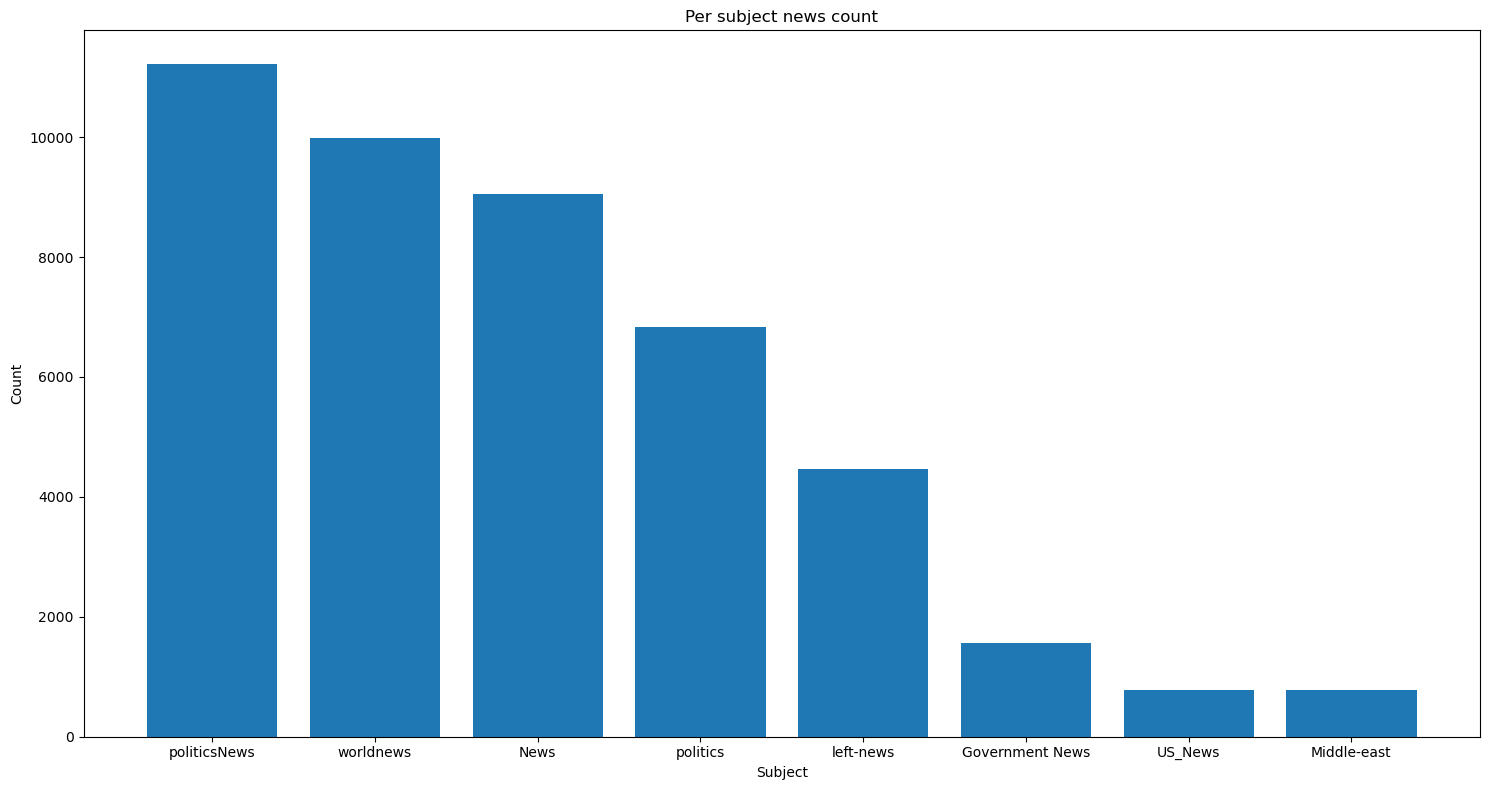

In [28]:
plt.figure(figsize = (15, 8))
plt.bar(subject_count.index, subject_count.values)
plt.xlabel("Subject")
plt.ylabel("Count")
plt.title("Per subject news count")
plt.tight_layout()

In [41]:
count = df.groupby(["subject", "label"]).size().unstack(fill_value = 0)

In [42]:
count

label,0,1
subject,,
Government News,1570,0
Middle-east,778,0
News,9050,0
US_News,783,0
left-news,4459,0
politics,6838,0
politicsNews,0,11220
worldnews,0,9991


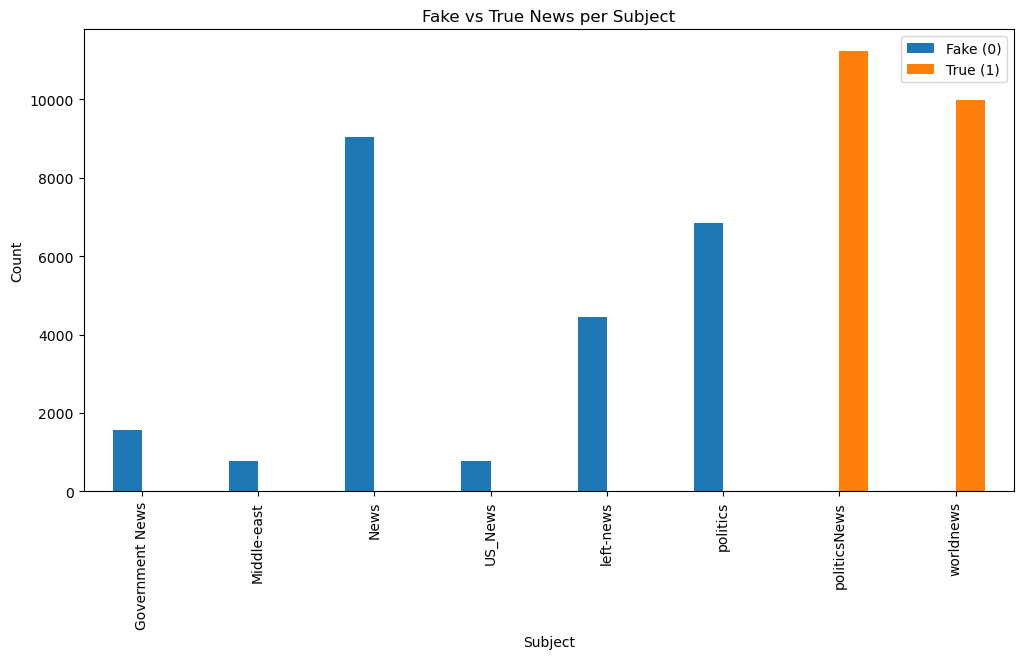

In [44]:
count.plot(kind="bar", figsize=(12,6))
plt.xlabel("Subject")
plt.ylabel("Count")
plt.title("Fake vs True News per Subject")
plt.legend(["Fake (0)", "True (1)"])
plt.show()

In [46]:
df = df.drop(columns = ["subject", "date"])
df.head()

,title,text,label
0,It’s Really Happening: Trump Adviser Lays Out...,"Well, that didn t take long. In the short time...",0
1,Republican attempt to deflect Trump-Russia pro...,(Reuters) - Republican lawmaker Devin Nunes’ i...,1
2,Trump says churches should get FEMA funds for ...,WASHINGTON (Reuters) - President Donald Trump ...,1
3,Trump Loves To Say The New York Times Is ‘Fai...,Print journalism and longstanding papers have ...,0
4,House Speaker Ryan briefed Trump on healthcare...,WASHINGTON (Reuters) - President Donald Trump ...,1


In [49]:
df["content"] = df["title"]+" "+df["text"]

In [50]:
X = df["content"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42
)

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [51]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

LogisticRegression()

In [52]:
y_pred = model.predict(X_test_tfidf)

In [53]:
from sklearn.metrics import accuracy_score, classification_report

print("Accuracy score: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy score:  0.98746923249049
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4739
           1       0.98      0.99      0.99      4199

    accuracy                           0.99      8938
   macro avg       0.99      0.99      0.99      8938
weighted avg       0.99      0.99      0.99      8938



In [58]:
def predict_news(news_text):
    vect = vectorizer.transform([news_text])
    pred = model.predict(vect)[0]
    return "TRUE News ✅" if pred == 1 else "FAKE News ❌"

print(predict_news("USA attack on Venezuela happened yesterday according to official reports and international media agencies..."))

FAKE News ❌


In [64]:
news_text ="""
USA launched an attack on Venezuela according to international media reports.
Officials have not confirmed the incident yet. Citizens were advised to stay safe.
"""
vect = vectorizer.transform([news_text])
proba = model.predict_proba(vect)[0]
print("Fake probability:", proba[0])
print("True probability:", proba[1])

Fake probability: 0.9083886512673507
True probability: 0.09161134873264927


In [67]:
import pickle

with open("fake_news_model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)